In [423]:
%reload_ext autoreload
%autoreload 2
%aimport -sklearn, matplotlib, numpy, seaborn

In [676]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import assessment 
import calibration 
%matplotlib inline

In [425]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

In [426]:
data = np.loadtxt('default.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed(0)
_X = data[:,1:-1]
_Y = data[:,-1].astype('int')
np.sum(_Y)/_Y.size

0.2212

In [427]:
# read all train and test data into a single matrix
data = np.loadtxt('default.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed()
X = data[:,1:-1]
Y = data[:,-1].astype('int')

# undersample class Y = 0
# Y0indices = np.where(Y == 0)[0]
# Y1indices = np.where(Y == 1)[0]
# Y0indices = np.random.choice(Y0indices, size=15000-len(Y1indices))
# X_subsampled = X[np.concatenate((Y0indices, Y1indices)), :]
# Y_subsampled = Y[np.concatenate((Y0indices, Y1indices))]

# indices = np.arange(X_subsampled.shape[0])
# np.random.shuffle(indices)
# X = X_subsampled[indices,:]
# Y = Y_subsampled[indices]

X = preprocessing.scale(X)

# create splits
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y, test_size=10000)
XTrain, XClient, YTrain, YClient = train_test_split(
    XTrain, YTrain, test_size=5000)
XTrain, XCalib, YTrain, YCalib = train_test_split(
    XTrain, YTrain, test_size=5000)

Train accuracy:  0.8109
Calibration accuracy:  0.8088


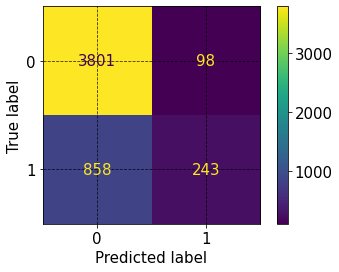

In [629]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(XTrain, YTrain)
#clf = RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=50).fit(XTrain, YTrain)
#clf = GradientBoostingClassifier().fit(XTrain, YTrain)

print('Train accuracy: ', clf.score(XTrain, YTrain))
print('Calibration accuracy: ', clf.score(XCalib, YCalib))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(YCalib, clf.predict(XCalib))).plot()

In [630]:
# remove some columns from the data
cols = list(range(XTrain.shape[1]))
cols_excl = []#5, 11, 17]
cols_select = [col for col in cols if not col in cols_excl]
# cols_incl = [0,1,2,3,4]
# cols_select = [col for col in cols_incl]

XTrain_select = XTrain[:,cols_select]
XCalib_select = XCalib[:,cols_select]

XClient_select = XClient[:,cols_select]
XTest_select = XTest[:,cols_select]

Train accuracy:  0.8316
Calibration accuracy:  0.8232


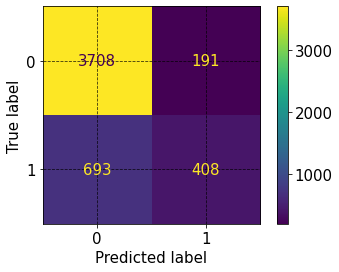

In [652]:
#clf_ = LogisticRegression(random_state=0, solver='lbfgs').fit(XTrain_select, YTrain)
#clf_ = RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=50).fit(XTrain_select, YTrain)
clf_ = GradientBoostingClassifier().fit(XTrain_select, YTrain)

print('Train accuracy: ', clf_.score(XTrain_select, YTrain))
print('Calibration accuracy: ', clf_.score(XCalib_select, YCalib))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(YCalib, clf_.predict(XCalib_select))).plot()

# Reliability diagram for model with selected columns

[2.980e+02 2.456e+03 2.470e+03 1.397e+03 9.080e+02 6.240e+02 2.930e+02
 1.710e+02 1.400e+02 9.300e+01 1.180e+02 1.780e+02 2.450e+02 1.960e+02
 2.220e+02 1.260e+02 5.100e+01 1.300e+01 1.000e+00 0.000e+00]


Text(0.5, 1.0, 'Random forest without recalibration')

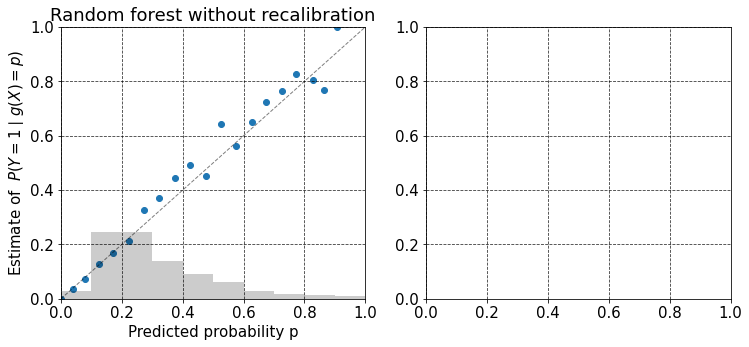

In [653]:
# get predicted probabilities for class 1 for logistic
predProb = clf_.predict_proba(XTest_select)[:,1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
assessment.reliability_diagram(YTest, predProb, ax[0], n_bins=20, fixed=True)
ax[0].set_title('Random forest without recalibration')

# Recalibration 

Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 516.  532.  513.  479. 1007. 1106.  463.  472.  482.  481.  455.  468.
  520.  521.  509.  513.  481.  482.]


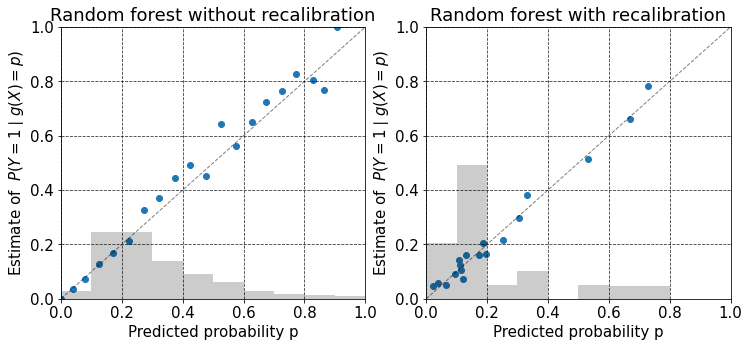

In [654]:
clfHB = calibration.Recalibrated_Classifier()
clfHB.base_clf = clf_
clfHB.n_bins = 20
clfHB.calibration_type = 'umd'
clfHB.fit(XCalib_select,YCalib)
#fig, ax = plt.subplots(figsize=(5.5,5))
#x_grid = np.linspace(0, 1, 1000)[1:-1]
#y_eval = clfHB.predict_proba(None, x_grid)

predProbHB = clfHB.predict_proba(XTest_select)
assessment.reliability_diagram(YTest, predProbHB, ax[1])
#ax.plot(x_grid, y_eval, '--', label='Histogram binning (B = 50)', color='g', linewidth=1)
ax[1].set_title('Random forest with recalibration')
fig

In [655]:
print(assessment.ece(YTest, predProb, n_bins=20))
print(assessment.ece(YTest, predProbHB))

Using 20 adaptive bins for ECE estimation.
0.01852777523210846
Classifier has discrete output. Further binning not done for ECE estimation.
0.0233932


In [656]:
np.unique(predProbHB)

array([0.024, 0.04 , 0.064, 0.096, 0.108, 0.112, 0.116, 0.12 , 0.132,
       0.172, 0.188, 0.196, 0.252, 0.304, 0.332, 0.532, 0.668, 0.728])

# Client-side analysis

In [657]:
# np.sum(data[:,6]=='-1')
# plt.hist(data[:,6])

In [658]:
category_column_index = 5
unique_vals_of_category = np.unique(XClient[:,category_column_index])
num_vals = unique_vals_of_category.size
unique_vals_of_category

array([-1.76484282, -0.87499115,  0.01486052,  0.90471219,  1.79456386,
        2.68441553,  3.57426721,  4.46411888,  5.35397055,  6.24382222,
        7.13367389])

In [659]:
binarized_category_client = (XClient[:,category_column_index] > 0.5)
unique_vals_of_category = np.unique(binarized_category_client)
num_vals = unique_vals_of_category.size

In [660]:
client_val_indices = []
XClient_categorized = []
YClient_categorized = []

for val in range(num_vals):
    client_val_indices += [np.where(binarized_category_client == unique_vals_of_category[val])]
    XClient_categorized += [XClient_select[client_val_indices[val],:].squeeze()]
    YClient_categorized += [YClient[client_val_indices[val]].squeeze()]
    
test_val_indices = []
XTest_categorized = []
YTest_categorized = []

binarized_category_test = (XTest[:,category_column_index] > 0.5)
for val in range(num_vals):
    test_val_indices += [np.where(binarized_category_test == unique_vals_of_category[val])]
    XTest_categorized += [XTest_select[test_val_indices[val],:].squeeze()]
    YTest_categorized += [YTest[test_val_indices[val]].squeeze()]

In [661]:
def create_category_wise_plots(clf, X, Y, X_categorized, Y_categorized):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    pred_proba = clf.predict_proba(X)
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y, pred_proba, ax[0])
    overall_ece = assessment.ece(Y, pred_proba)
    ax[0].set_title("Overall ECE = {:f}".format(overall_ece))
    
    pred_proba = clf.predict_proba(X_categorized[0])
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y_categorized[0], pred_proba, ax[1])
    cat_1_ece = assessment.ece(Y_categorized[0], pred_proba)
    ax[1].set_title("Category 1 ECE = {:f}".format(cat_1_ece))

    pred_proba = clf.predict_proba(X_categorized[1])
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y_categorized[1], pred_proba, ax[2])
    cat_2_ece = assessment.ece(Y_categorized[1], pred_proba)
    ax[2].set_title("Category 2 ECE = {:f}".format(cat_2_ece))

    # assessment.reliability_diagram(YClient_categorized[3], clfHB.predict_proba(XClient_categorized[3]), ax[3])
    # ax[3].set_title('Category 3 reliability diagram')

Using 10 adaptive bins for plotting reliability diagram.
[500. 500. 500. 500. 500. 500. 500. 500. 500. 500.]
Using 15 adaptive bins for ECE estimation.
Using 10 adaptive bins for plotting reliability diagram.
[382. 382. 381. 381. 381. 381. 381. 381. 381. 381.]
Using 15 adaptive bins for ECE estimation.
Using 10 adaptive bins for plotting reliability diagram.
[119. 119. 119. 119. 119. 119. 119. 119. 118. 118.]
Using 15 adaptive bins for ECE estimation.


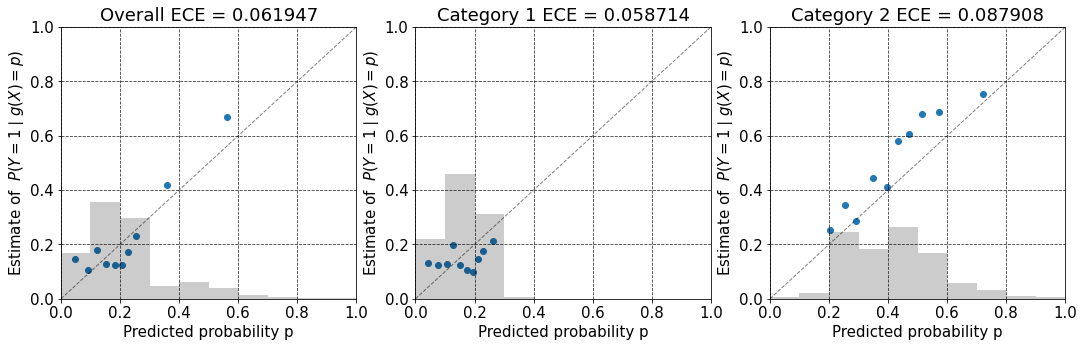

In [662]:
create_category_wise_plots(clf, XClient, YClient, XClient_categorized, YClient_categorized)

Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 516.  532.  513.  479. 1007. 1106.  463.  472.  482.  481.  455.  468.
  520.  521.  509.  513.  481.  482.]
Classifier has discrete output. Further binning not done for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 506.  520.  502.  472.  949. 1068.  453.  463.  460.  475.  397.  440.
  428.  295.  203.  102.    8.    2.]
Classifier has discrete output. Further binning not done for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 10.  12.  11.   7.  58.  38.  10.   9.  22.   6.  58.  28.  92. 226.
 306. 411. 473. 480.]
Classifier has discrete output. Further binning not done for ECE estimation.


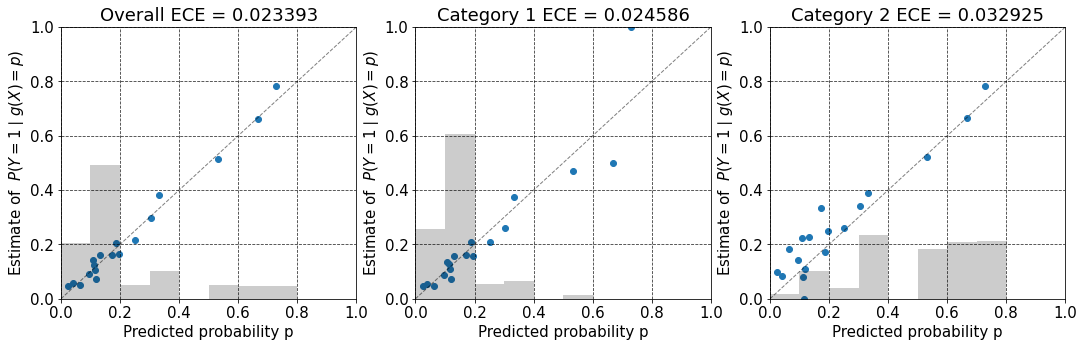

In [663]:
create_category_wise_plots(clfHB, XTest, YTest, XTest_categorized, YTest_categorized)

In [664]:
print('Test accuracy: ', clfHB.score(XTest, YTest))

Test accuracy:  0.8206


In [665]:
binarized_category_test = (XTest[:,category_column_index] > 0.5)
arr = YTest[np.where((clfHB.predict_proba(XTest) > 0.5) * (binarized_category_test == False))]
np.sum(arr)/arr.size

0.48214285714285715

In [666]:
clfClient_cat0 = calibration.Recalibrated_Classifier()
clfClient_cat0.base_clf = clfHB
clfClient_cat0.n_bins = 10
clfClient_cat0.calibration_type = 'umd'
clfClient_cat0.fit(XClient_categorized[0],YClient_categorized[0])

clfClient_cat1 = calibration.Recalibrated_Classifier()
clfClient_cat1.base_clf = clfHB
clfClient_cat1.n_bins = 10
clfClient_cat1.calibration_type = 'umd'
clfClient_cat1.fit(XClient_categorized[1],YClient_categorized[1])


In [667]:
def create_category_wise_plots_2(clf, X, Y, X_categorized, Y_categorized):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), constrained_layout="True")

    pred_proba = clf.predict_proba(X)
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y, pred_proba, ax[0,0])
    overall_ece = assessment.ece(Y, pred_proba)
    ax[0,0].set_title("Overall ECE = {:f}".format(overall_ece))
    assessment.reliability_diagram(Y, pred_proba, ax[1,0])
    overall_ece = assessment.ece(Y, pred_proba)
    ax[1,0].set_title("Overall ECE = {:f}".format(overall_ece))
    
    pred_proba = clf.predict_proba(X_categorized[0])
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y_categorized[0], pred_proba, ax[0, 1])
    cat_1_ece = assessment.ece(Y_categorized[0], pred_proba)
    ax[0,1].set_title("Category 1 ECE = {:f}".format(cat_1_ece))

    assessment.reliability_diagram(Y_categorized[0], clfClient_cat0.predict_proba(X_categorized[0]), ax[1,1])
    cat_1_ece = assessment.ece(Y_categorized[0], clfClient_cat0.predict_proba(X_categorized[0]))
    ax[1,1].set_title("Category 1 ECE = {:f}".format(cat_1_ece))

    pred_proba = clf.predict_proba(X_categorized[1])
    if len(pred_proba.shape) == 2:
        pred_proba = pred_proba[:,1].squeeze()
    assessment.reliability_diagram(Y_categorized[1], pred_proba, ax[0,2])
    cat_2_ece = assessment.ece(Y_categorized[1], pred_proba)
    ax[0,2].set_title("Category 2 ECE = {:f}".format(cat_2_ece))

    assessment.reliability_diagram(Y_categorized[1], clfClient_cat1.predict_proba(X_categorized[1]), ax[1,2])
    cat_2_ece = assessment.ece(Y_categorized[1], clfClient_cat1.predict_proba(X_categorized[1]))
    ax[1,2].set_title("Category 2 ECE = {:f}".format(cat_2_ece))

    # assessment.reliability_diagram(YClient_categorized[3], clfHB.predict_proba(XClient_categorized[3]), ax[3])
    # ax[3].set_title('Category 3 reliability diagram')

Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 516.  532.  513.  479. 1007. 1106.  463.  472.  482.  481.  455.  468.
  520.  521.  509.  513.  481.  482.]
Classifier has discrete output. Further binning not done for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 516.  532.  513.  479. 1007. 1106.  463.  472.  482.  481.  455.  468.
  520.  521.  509.  513.  481.  482.]
Classifier has discrete output. Further binning not done for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[ 506.  520.  502.  472.  949. 1068.  453.  463.  460.  475.  397.  440.
  428.  295.  203.  102.    8.    2.]
Classifier has discrete output. Further binning not done for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[1026.  502.  472.  475. 1521.  949.  923.  837. 1038.]
Classifier has d

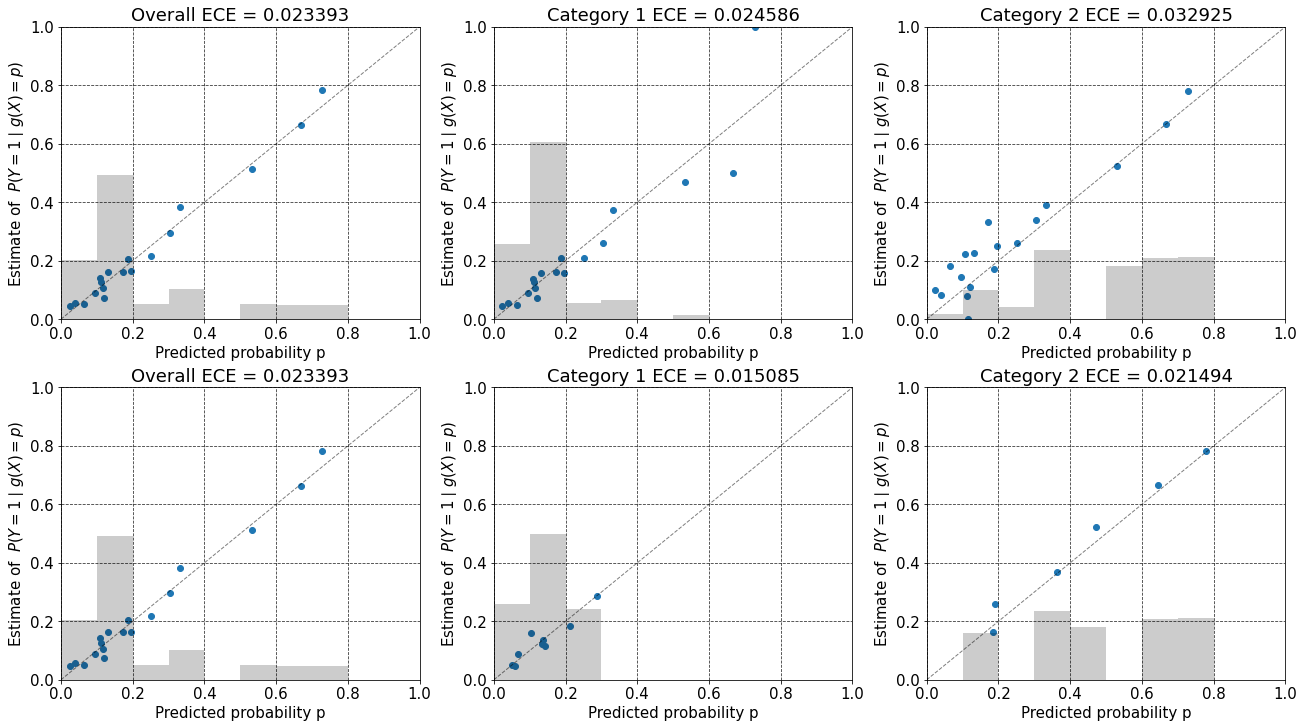

In [668]:
create_category_wise_plots_2(clfHB, XTest, YTest, XTest_categorized, YTest_categorized)